<a href="https://colab.research.google.com/github/davidogm/PD/blob/main/amp_pd_shap_lime_publicdata_merged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 AMP-PD: Parkinson’s Disease Progression Prediction (Colab Notebook)
Este cuaderno realiza un flujo completo para predicción de progresión de Parkinson a partir de datos clínicos, proteómicos y peptídicos del conjunto **AMP-PD**.

Incluye:
- Descarga y preprocesamiento de datos
- Entrenamiento con LightGBM
- Explicabilidad con **SHAP** y **LIME**

**⚠️ Requiere API de Kaggle activa.**

In [1]:
# 🔧 Instalación de librerías necesarias
!pip install kaggle shap lime lightgbm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# 🔄 Cargar kaggle.json desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [3]:
# 📦 Descargar datos desde dataset público (no competición)
!kaggle datasets download -d adityavartak/amp-parkinsons-disease-progression-data
!unzip -o amp-parkinsons-disease-progression-data.zip -d amp_pd

Dataset URL: https://www.kaggle.com/datasets/adityavartak/amp-parkinsons-disease-progression-data
License(s): unknown
  0% 0.00/6.14M [00:00<?, ?B/s]
100% 6.14M/6.14M [00:00<00:00, 500MB/s]
Archive:  amp-parkinsons-disease-progression-data.zip
  inflating: amp_pd/clinical_offset_train.csv  
  inflating: amp_pd/peptide_udprs_1_top_10.csv  
  inflating: amp_pd/peptide_udprs_2_top_10.csv  
  inflating: amp_pd/peptide_udprs_3_top_10.csv  
  inflating: amp_pd/peptide_udprs_4_top_10.csv  
  inflating: amp_pd/protein_udprs_1_top_10.csv  
  inflating: amp_pd/protein_udprs_2_top_10.csv  
  inflating: amp_pd/protein_udprs_3_top_10.csv  
  inflating: amp_pd/protein_udprs_4_top_10.csv  
  inflating: amp_pd/train_all.csv    


In [4]:
# ✅ Verificar autenticación con Kaggle
!kaggle datasets list -s parkinsons | head -n 10

ref                                                           title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
thecansin/parkinsons-data-set                                  Parkinsons Data Set                                     17517  2019-11-08 07:19:15.887000          10661         88  0.5              
itsmesunil/parkinsons                                         parkinsons                                               15974  2020-02-08 05:35:34.473000           1035          6  0.9375           
gargmanas/parkinsonsdataset                                   Parkinson's Disease Dataset                              15870  2021-04-29 08:15:50.707000           4229         78  0.7352941        
imkrkannan

In [5]:
# ✅ Carga segura con merge flexible
import pandas as pd

# Cargar datos públicos descargados
clinical = pd.read_csv('/content/amp_pd/train_all.csv')
proteins = pd.read_csv('/content/amp_pd/protein_udprs_1_top_10.csv')

# Renombrar si es necesario
if 'subject_id' in proteins.columns:
    proteins.rename(columns={'subject_id': 'participant_id'}, inplace=True)

# Verificar columnas disponibles
print("🔎 clinical:", clinical.columns.tolist())
print("🔎 proteins:", proteins.columns.tolist())

# Selección de columns comunes compatibles
# Based on the next cell, the merge should be on visit_id, visit_month, and participant_id
join_keys = ['visit_id', 'visit_month', 'participant_id']

if all(col in clinical.columns for col in join_keys) and all(col in proteins.columns for col in join_keys):
    print("✅ Haciendo merge con columnas:", join_keys)
    df = clinical.merge(proteins, on=join_keys, how='left')
else:
    print("❌ Las columnas para hacer merge no se encuentran en ambos dataframes.")
    # Fallback to merging on available common columns if the ideal keys are not present
    # This part might need adjustment based on the actual content of the dataframes
    common_cols = list(set(clinical.columns) & set(proteins.columns))
    if len(common_cols) >=1:
      print("✅ Haciendo merge con columnas comunes:", common_cols)
      df = clinical.merge(proteins, on=common_cols, how='left')
    else:
      raise ValueError("❌ No hay columnas comunes adecuadas para hacer merge.")

# Mostrar primeras filas
df.head()

🔎 clinical: ['O00391', 'O00533', 'O00584', 'O14498', 'O14773', 'O14791', 'O15240', 'O15394', 'O43505', 'O60888', 'O75144', 'O75326', 'O94919', 'P00441', 'P00450', 'P00734', 'P00736', 'P00738', 'P00746', 'P00747', 'P00748', 'P00751', 'P01008', 'P01009', 'P01011', 'P01019', 'P01023', 'P01024', 'P01031', 'P01033', 'P01034', 'P01042', 'P01344', 'P01591', 'P01608', 'P01621', 'P01717', 'P01780', 'P01833', 'P01834', 'P01857', 'P01859', 'P01860', 'P01861', 'P01876', 'P01877', 'P02452', 'P02647', 'P02649', 'P02652', 'P02655', 'P02656', 'P02671', 'P02675', 'P02679', 'P02747', 'P02748', 'P02749', 'P02750', 'P02751', 'P02753', 'P02760', 'P02763', 'P02765', 'P02766', 'P02768', 'P02774', 'P02787', 'P02790', 'P04004', 'P04075', 'P04156', 'P04180', 'P04196', 'P04207', 'P04211', 'P04216', 'P04217', 'P04275', 'P04406', 'P04433', 'P05060', 'P05067', 'P05090', 'P05155', 'P05156', 'P05408', 'P05452', 'P05546', 'P06310', 'P06396', 'P06454', 'P06681', 'P06727', 'P07195', 'P07225', 'P07333', 'P07339', 'P07602

ValueError: ❌ No hay columnas comunes adecuadas para hacer merge.

In [6]:
# 🔍 Preprocessing and data preparation
import pandas as pd

# Use the clinical dataframe directly
df = clinical.copy()

# Rename the target column
df = df.rename(columns={'updrs_1': 'target'})

# Handle missing values and drop rows with insufficient data
df = df.dropna(thresh=10) # Keep rows with at least 10 non-NaN values

# Select only numeric columns for median calculation
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median()) # Fill remaining NaNs in numeric columns with the median

df = df.dropna() # Drop any remaining rows with NaNs (e.g., columns that were all NaN or non-numeric)

print(df.shape)
df.head()

(1068, 1201)


,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,RYIETDPANRDR,ADSGEGDFLAEGGGVR,ISLPESLKR,QLNEINYEDHK,LLRDPADASEAHESSSR,visit_month,target,updrs_2,updrs_3,updrs_4
0,11254.3,732430.0,39585.8,41526.9,31238.00,4202.71,177775.0,62898.2,333376.0,166850.0,...,0.00,0.0,0.0,0.0,0.0,0,10.0,6.0,15.0,0.0
1,11648.9,419015.0,35053.8,0.0,17466.30,2784.40,118752.0,40274.9,166322.0,93873.7,...,17285.70,29836.9,12349.7,10234.4,33524.1,0,11.0,6.0,25.0,5.0
2,21361.8,866985.0,32035.1,0.0,13373.10,0.00,269106.0,81580.2,315740.0,297865.0,...,29783.00,28644.6,27617.2,0.0,69167.7,0,2.0,0.0,0.0,0.0
3,0.0,579829.0,28259.8,29883.2,19134.10,1884.61,134409.0,70664.8,213295.0,229999.0,...,17292.50,23444.6,9064.5,0.0,23237.4,0,2.0,0.0,0.0,0.0
4,10887.0,267402.0,11390.4,15696.3,6646.16,2962.85,61555.3,25927.8,72635.7,110550.0,...,9084.45,44698.9,19223.7,0.0,13106.9,0,1.0,2.0,9.0,0.0


In [7]:
# 🧠 Entrenamiento de modelo con LightGBM
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Drop target and other non-feature columns, including the non-numeric 'visit_id'
X = df.drop(columns=['target', 'updrs_2', 'updrs_3', 'updrs_4', 'visit_id'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, preds))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292541
[LightGBM] [Info] Number of data points in the train set: 854, number of used features: 1196
[LightGBM] [Info] Start training from score 6.654567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MAE: 3.473084081280354


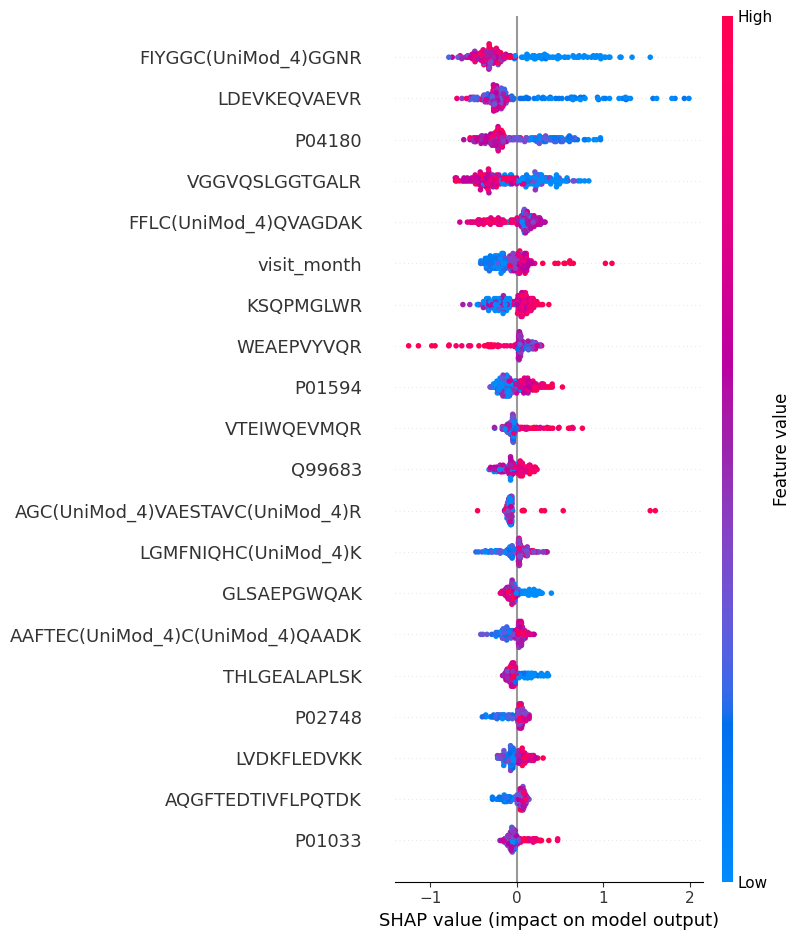

In [8]:
# 📈 SHAP: explicabilidad global
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

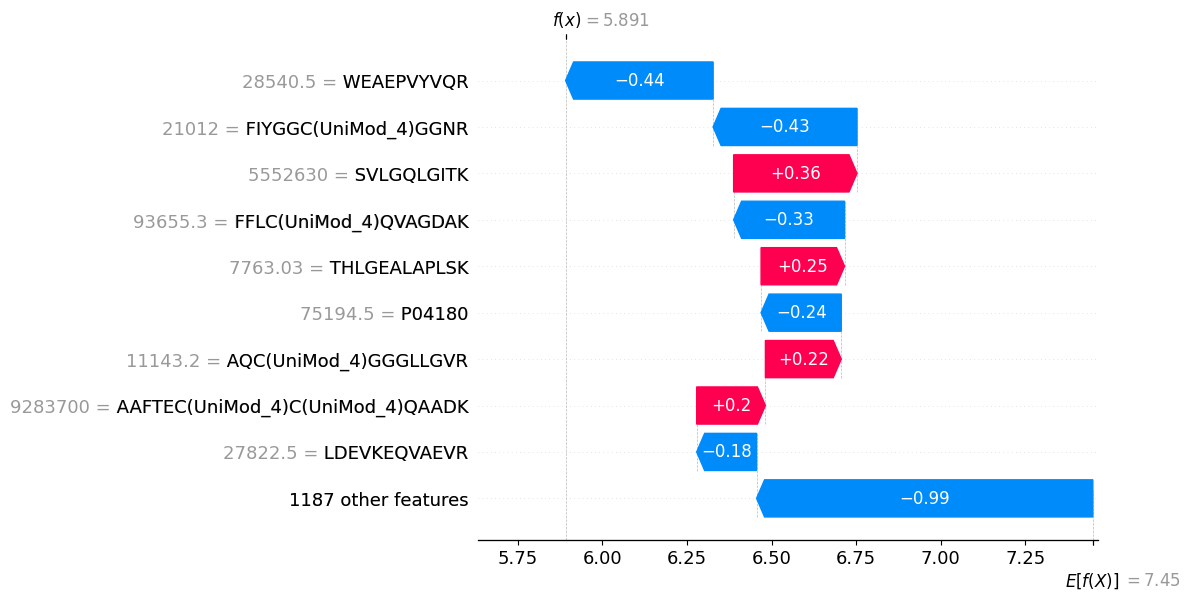

In [9]:
# 📌 SHAP: visualización individual y guardado de explicaciones
i = 0  # índice de la instancia
shap.plots.waterfall(shap_values[i])

# Guardar valores SHAP a CSV
shap_df = pd.DataFrame(shap_values[i].values, index=X_test.columns, columns=['SHAP value'])
shap_df.to_csv(f'shap_explanation_instance_{i}.csv')

In [10]:
# 🔍 LIME: explicación local para una instancia
import lime
import lime.lime_tabular

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns.tolist(), verbose=True, mode='regression'
)
i = 0
exp = explainer_lime.explain_instance(X_test.values[i], model.predict, num_features=10)
exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Intercept 7.883410722021587
Prediction_local [6.29936316]
Right: 5.891417323011937
